In [55]:
from glob import glob
import os
%pylab
%matplotlib inline
import seaborn as sns
import SimpleITK as sitk
from tqdm import tqdm

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [56]:
path = "/ocean/projects/asc170022p/lisun/registration/INSP2Atlas/image_transformed"
maskpath = "/ocean/projects/asc170022p/lisun/registration/INSP2Atlas/unet_mask_transformed"

allfiles = glob("{}/*".format(path))
allmasks = glob("{}/*".format(maskpath))

In [57]:
allfiles[:10]

['/ocean/projects/asc170022p/lisun/registration/INSP2Atlas/image_transformed/14967Q_INSP_STD_TEM_COPD_Reg_19676E.nii.gz',
 '/ocean/projects/asc170022p/lisun/registration/INSP2Atlas/image_transformed/22744S_INSP_STD_BWH_COPD_Reg_19676E.nii.gz',
 '/ocean/projects/asc170022p/lisun/registration/INSP2Atlas/image_transformed/16475F_INSP_STD_USD_COPD_Reg_19676E.nii.gz',
 '/ocean/projects/asc170022p/lisun/registration/INSP2Atlas/image_transformed/22106M_INSP_STD_TXS_COPD_Reg_19676E.nii.gz',
 '/ocean/projects/asc170022p/lisun/registration/INSP2Atlas/image_transformed/14506G_INSP_STD_TXS_COPD_Reg_19676E.nii.gz',
 '/ocean/projects/asc170022p/lisun/registration/INSP2Atlas/image_transformed/25796A_INSP_STD_HAR_COPD_Reg_19676E.nii.gz',
 '/ocean/projects/asc170022p/lisun/registration/INSP2Atlas/image_transformed/24341G_INSP_STD_NJC_COPD_Reg_19676E.nii.gz',
 '/ocean/projects/asc170022p/lisun/registration/INSP2Atlas/image_transformed/12282A_INSP_STD_JHU_COPD_Reg_19676E.nii.gz',
 '/ocean/projects/asc170

In [58]:
img = sitk.GetArrayFromImage(sitk.ReadImage(allfiles[0]))

In [59]:
len(allfiles)

9255

In [6]:
2473861/9255

267.29994597514855

# Lung Mask

In [7]:
mask = list(filter(lambda x: '14967Q' in x, allmasks))[0]
print(mask)

/ocean/projects/asc170022p/lisun/registration/INSP2Atlas/unet_mask_transformed/14967Q_INSP_STD_TEM_COPD_Reg_19676E_Affine.nii.gz


In [8]:
maskimg = sitk.GetArrayFromImage(sitk.ReadImage(mask))

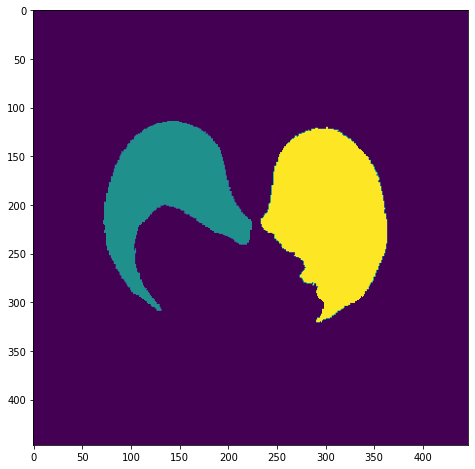

In [9]:
plt.figure(figsize=(8,8))
plt.imshow(maskimg[100],)

In [10]:
maskimg.shape

(379, 447, 447)

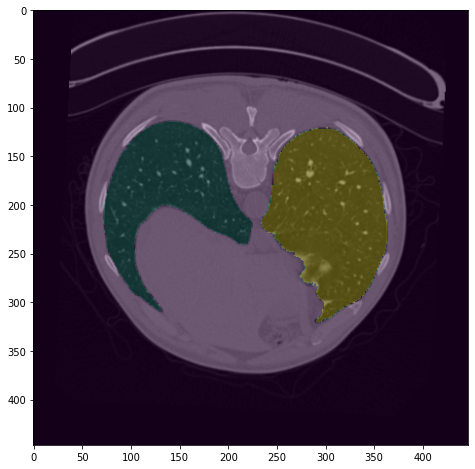

In [11]:
plt.figure(figsize=(8, 8))
plt.imshow(img[100], 'gray')
plt.imshow(maskimg[100], alpha=0.3)

In [12]:
print(img[-1].max(), img[-1].min())

-1024 -1024


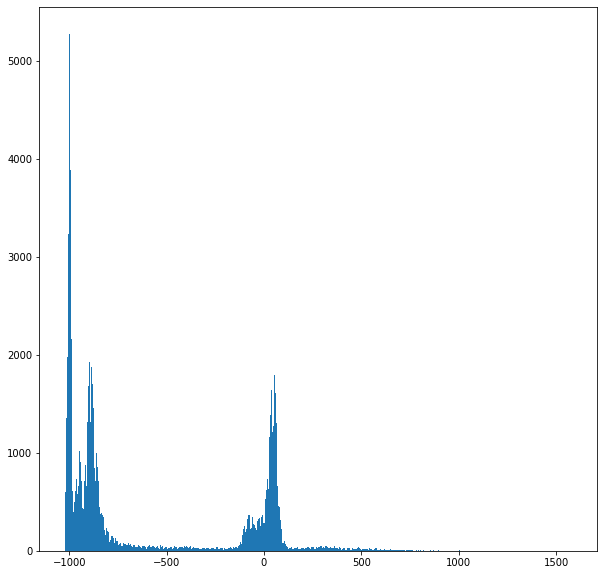

In [13]:
arr = img[231].reshape(-1)
arr = arr[arr > -1024]
# print(len(arr), len(img[100].reshape(-1)))
plt.figure(figsize=(10, 10))
x = plt.hist(arr, bins=1000)

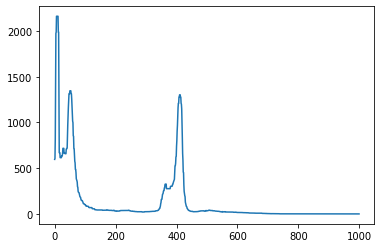

In [14]:
from scipy.signal import medfilt
plt.plot(medfilt(x[0], 15))

# Store image slice statistics

In [21]:
import multiprocessing as mp

In [22]:
outputdir = '/ocean/projects/asc170022p/rohit33/COPDslices/slices'
outputfileindex = '/ocean/projects/asc170022p/rohit33/COPDslices/emphysemaindex/'
outputpatientindex = '/ocean/projects/asc170022p/rohit33/COPDslices/patientemphysemaindex/'

In [23]:
N_slices = img.shape[0]

In [24]:
def return_emphysema_count(sid):
    global outputdir
    
    outpatientfile = '{}/{}.txt'.format(outputpatientindex, sid)
    if os.path.exists(outpatientfile):
        print("")
        return
    
    # Given subject ID, calculate emphysema count for all indices and return array
    imgfile = glob("/ocean/projects/asc170022p/lisun/registration/INSP2Atlas/image_transformed/{}*".format(sid))[0]
    try:
        maskfile = glob("/ocean/projects/asc170022p/lisun/registration/INSP2Atlas/unet_mask_transformed/{}*".format(sid))[0]
    except:
        print("No maskfile found for sid {}".format(sid))

    # Given subject ID, and mask file
    img = sitk.GetArrayFromImage(sitk.ReadImage(imgfile))
    mask = sitk.GetArrayFromImage(sitk.ReadImage(maskfile))
    
    # Get emphysema and mask
    emph = (img <= -950).astype(int)
    mask = (mask > 0).astype(int)
    # Get count
    emph = (emph*mask).sum(-1).sum(-1)
    mask = mask.sum(-1).sum(-1)
    
    # Also save images while at it
    for i in range(img.shape[0]):
        outfile = '{}/{}_{}.npy'.format(outputdir, sid, i)
        # If output image doesn't exist, save it
        if not os.path.exists(outfile):  
            np.save(outfile, img[i])
    
    # Save patients
    normalized_emph = emph/mask
    np.savetxt(outpatientfile, normalized_emph)
    
    # return sid, emph/mask

In [25]:
subject_ids = list(map(lambda x: x.split('/')[-1].split('_')[0], allfiles))
print(subject_ids[:10])

['14967Q', '22744S', '16475F', '22106M', '14506G', '25796A', '24341G', '12282A', '19025P', '22142Q']


In [26]:
res = [return_emphysema_count(x) for x in subject_ids[1000:1001]]

In [27]:
num_cores = mp.cpu_count()

In [28]:
num_cores

40

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
with mp.Pool(num_cores) as pool:
    pool.map(return_emphysema_count, subject_ids)

# Sort by slice index 

In [60]:
slicetosubject = dict()
for i in range(379):
    slicetosubject[i] = []

In [61]:
for file in tqdm(glob("{}*".format(outputpatientindex))):
    sid = file.split('/')[-1].split('.')[0]
    subcount = np.loadtxt(file)
    for i, val in enumerate(subcount):
        slicetosubject[i].append((sid, val))

100%|██████████| 9255/9255 [02:32<00:00, 60.66it/s]


In [73]:
for k in slicetosubject.keys():
    slicetosubject[k] = sorted(slicetosubject[k], key=lambda x: float(x[1]) if not np.isnan(x[1]) else np.inf)

In [75]:
for k, v in slicetosubject.items():
    v = np.array(v)
    np.savetxt('{}{}.txt'.format(outputfileindex, k), v, fmt='%s,%s')

In [74]:
for i in slicetosubject[100]:
    print(i)

('18080S', 0.0)
('14501W', 0.0)
('11241H', 0.0)
('17319W', 0.0)
('20428Y', 0.0)
('19416E', 0.0)
('24996D', 0.0)
('19018S', 0.0)
('21327X', 0.0)
('20728K', 0.0)
('14851X', 0.0)
('22959N', 0.0)
('18157B', 0.0)
('24266S', 0.0)
('16264S', 0.0)
('20327S', 0.0)
('17324P', 0.0)
('12871T', 0.0)
('25614U', 0.0)
('21872W', 0.0)
('24962M', 0.0)
('22467S', 0.0)
('16839R', 0.0)
('19267N', 0.0)
('14748E', 0.0)
('19049D', 0.0)
('19789R', 0.0)
('20775T', 0.0)
('10476D', 0.0)
('23421Z', 0.0)
('13892G', 0.0)
('22397X', 0.0)
('15186T', 0.0)
('21667V', 0.0)
('19787N', 0.0)
('11502J', 0.0)
('22388W', 0.0)
('21212G', 0.0)
('21818Q', 0.0)
('25975A', 0.0)
('14116T', 0.0)
('24613N', 0.0)
('21746R', 0.0)
('16240E', 0.0)
('17973A', 0.0)
('24030P', 0.0)
('10853H', 0.0)
('15139K', 0.0)
('15362N', 0.0)
('17957C', 0.0)
('19621F', 0.0)
('16992Z', 0.0)
('24411B', 0.0)
('25132C', 0.0)
('21801Z', 0.0)
('13868J', 0.0)
('21948D', 0.0)
('24874P', 0.0)
('25422L', 0.0)
('22766C', 0.0)
('20033B', 0.0)
('19073A', 0.0)
('11573G

('16631T', 0.0009791122715404699)
('10991T', 0.0009802853719638384)
('17736M', 0.000981243159602974)
('19731M', 0.000983410295878228)
('14055Z', 0.000983735571878279)
('21684V', 0.0009837484751898634)
('18146W', 0.0009859154929577464)
('20895D', 0.0009860492294207874)
('10936L', 0.0009862293165796105)
('26125K', 0.0009876918401458745)
('21246X', 0.0009886656544613537)
('22808S', 0.0009912258159256947)
('15842B', 0.0009926215134169341)
('20664K', 0.0009939699158438805)
('14977T', 0.0009949188075187435)
('14207W', 0.0009954139855664972)
('24349W', 0.0009959424566580598)
('18785E', 0.0010021865889212828)
('24671B', 0.0010033626206746935)
('23337K', 0.001003705991352687)
('11523R', 0.0010051373687737324)
('13972E', 0.001006082224356336)
('15058K', 0.0010094058270245468)
('11878C', 0.001009822821995777)
('13733M', 0.0010102521888797425)
('21128R', 0.0010116833104888716)
('17578U', 0.0010118589873315254)
('20004U', 0.0010130922693266833)
('20414N', 0.0010148628298304197)
('18377P', 0.0010149

('12050F', 0.033089457931493184)
('13807P', 0.03315804389583399)
('25991Y', 0.033200766990980755)
('26078B', 0.03321315415710696)
('23610C', 0.03321922593265335)
('21604X', 0.03328697264719518)
('21239A', 0.03330909594543125)
('14722M', 0.033313531051501165)
('13959M', 0.033346245722771)
('15828H', 0.03334641035700275)
('25797C', 0.03334977799703996)
('23236E', 0.03335597826086956)
('23587H', 0.03336127409891031)
('11408R', 0.033362961081836076)
('21063P', 0.03336517467248908)
('11323J', 0.033366518840317376)
('19943B', 0.033370660694288914)
('13422V', 0.03337979094076655)
('17770M', 0.033397966048039254)
('24270J', 0.03341000350863514)
('16939V', 0.03347059792455938)
('15575E', 0.033477011494252876)
('14924Y', 0.033479322833319294)
('18938D', 0.0334837330800285)
('19096M', 0.033484081583755126)
('11419W', 0.03349586601653593)
('23283N', 0.033518222343212986)
('22977P', 0.0335254404742302)
('11776U', 0.03355106888361045)
('17932M', 0.0335577212900633)
('12719N', 0.033576069419613656)
(